In [1]:
import osmnx as ox
import networkx as nx
import pandas as pd
import numpy as np
import os
import main
import SARSA
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning) 
warnings.simplefilter(action='ignore',category=RuntimeWarning) 
warnings.simplefilter(action='ignore',category=DeprecationWarning)

In [2]:
def check_folders():
    if os.path.isdir('./Input'):
        try:
            os.rename('./Input','CAREFUL_PREVIOUS_INPUT')
        except:
            print('MOVE OR ERASE PREVIOUS IMPUT FOLDER')
    os.makedirs('./Input')
    os.makedirs('./Input/StatesMatrices')

def download_nwk(lat=38.435220,lon=141.303816,radius=1000,show=True, save=True):
    G = ox.graph_from_point(center_point=(lat,lon), network_type='all', dist=radius, simplify=True)
    fig, ax = ox.plot_graph(G,node_color='blue',bgcolor='white', show=show, save=save,filepath='./Input/nwk_simple.png')
    G_proj = ox.project_graph(G)
    # G = nx.Graph(G)
    return G_proj

node_ids = {}
def get_nodedb(G,evacnodes=[0]): #<=== change this to the node id of the evacuation node
    node_coords = {}
    for i, node in enumerate(G.nodes(data=True)):
        node_ids[i] = node[0]
        node_coords[node[0]] = node[1]['x'],node[1]['y']
    Gdfn = pd.DataFrame(node_coords).T
    Gdfn.columns = ['Coord_x','Coord_y']
    Gdfn.reset_index(inplace=True)
    Gdfn.index = list(node_ids.values())
    Gdfn['#number'] = list(node_ids.keys()) #Gdfn.index.astype(np.float64)
    Gdfn['Coord_x'] = Gdfn['Coord_x'].astype(np.float64)
    Gdfn['Coord_y'] = Gdfn['Coord_y'].astype(np.float64)
    Gdfn = Gdfn[['#number','Coord_x','Coord_y']]
    Gdfn['evacuation'] = 0
    Gdfn['reward'] = 1
    for node in evacnodes:
        #find the node in Gdfn index
        Gdfn.loc[Gdfn.index == node,'evacuation'] = 1
    # Gdfn = Gdfn.sort_index()
    # Gdfn_new = Gdfn.reset_index()
    # Gdfn_new['#number'] = Gdfn_new.index.astype(np.float64)
    # Gdfn_new = Gdfn_new.drop(columns='index')
    Gdfn.to_csv('./Input/nodes.csv',index=False)
    return Gdfn

edge_ids = {}
def get_edgedb(G):
    # id = []
    node1 = []
    node2 = []
    length = []
    for j,edge in enumerate(G.edges(data=True)):
        if type(edge[2]['osmid']) is not list:
            osmid = edge[2]['osmid']
        else:
            osmid = edge[2]['osmid'][0]
        edge_ids[j] = osmid
        # id.append(osmid)
        length.append(edge[2]['length'])
        node1.append(list(node_ids.values()).index(edge[:2][0])) #maybe error if the node is not yet looked up
        node2.append(list(node_ids.values()).index(edge[:2][1]))
    Gdfe = pd.DataFrame()
    Gdfe.index = list(edge_ids.values())
    Gdfe['#number'] = list(edge_ids.keys())#id
    Gdfe['Node1'] = node1
    Gdfe['Node2'] = node2
    Gdfe['Length'] = length
    Gdfe['Width'] = 3
    Gdfe['#number'] = Gdfe['#number'].astype(np.float64)
    Gdfe['Node1'] = Gdfe['Node1'].astype(np.float64)
    Gdfe['Node2'] = Gdfe['Node2'].astype(np.float64)
    Gdfe['Length'] = Gdfe['Length'].astype(np.float64)
    Gdfe = Gdfe.sort_index()
    Gdfe_new = Gdfe.reset_index()
    Gdfe_new['#number'] = Gdfe_new.index.astype(np.float64)
    Gdfe_new = Gdfe_new.drop(columns='index')
    Gdfe_new.to_csv('./Input/edges.csv',index=False)
    return Gdfe_new

def get_fake_population(times=1):
    df = pd.read_csv('./Input/nodes.csv')    
    pop = pd.DataFrame()
    pop['#age'] = np.zeros(df.shape[0] * times)
    pop['Gender'] = np.zeros(df.shape[0] * times)
    pop['Hh Type'] = np.zeros(df.shape[0] * times)
    pop['Hh Id'] = np.zeros(df.shape[0] * times)
    pop['Node'] = list(df['#number']) * times
    pop.sort_values(by='Node')
    pop.reset_index()
    pop.to_csv('./Input/population.csv', index=False)
    
def get_actionsdb_transitionsdb():
    nodesdb = np.loadtxt("./Input/nodes.csv", delimiter=',', skiprows=1)
    linksdb = np.loadtxt("./Input/edges.csv", delimiter=',', skiprows=1)
    numNodes = nodesdb.shape[0]
    numLinks = linksdb.shape[0]
    
    actionsdb = np.zeros((numNodes, 12), dtype=np.int32)
    transitionsdb = np.zeros((numNodes, 12), dtype=np.int32)
    probdb = np.zeros((numNodes, 12), dtype=np.int32) 
    rewarddb = np.zeros((numNodes, 12), dtype=np.int32) 
    
    for i in range(numNodes):
        actionsdb[i,0] = nodesdb[i,0]
        transitionsdb[i,0] = nodesdb[i,0]
        rewarddb[i,0] = nodesdb[i,0]
        
        if nodesdb[i,3]:
            actionsdb[i,1] = 1
            actionsdb[i,2] = -1
            transitionsdb[i,1] = 1
            transitionsdb[i,2] = actionsdb[i,0]
            rewarddb[i,1] = 1
            rewarddb[i,2] = 0
            continue
            
        tmpLinksdb1 = linksdb[linksdb[:,1] == nodesdb[i,0]]
        tmpLinksdb2 = linksdb[linksdb[:,2] == nodesdb[i,0]]
        numlinks1 = tmpLinksdb1.shape[0]
        numlinks2 = tmpLinksdb2.shape[0]
        
        actionsdb[i,1] = numlinks1 + numlinks2
        transitionsdb[i,1] = numlinks1 + numlinks2
        rewarddb[i,1] = numlinks1 + numlinks2
        
        if numlinks1:
            actionsdb[i, 2: 2+numlinks1] = tmpLinksdb1[:,0]
            transitionsdb[i,2:2 + numlinks1] = tmpLinksdb1[:,2]
            rewarddb[i, 2:2+numlinks1] = -tmpLinksdb1[:,3]
        
        if numlinks2:
            actionsdb[i, 2+numlinks1 : 2+numlinks1+numlinks2] = tmpLinksdb2[:,0]
            transitionsdb[i, 2+numlinks1 : 2+numlinks1+numlinks2] = tmpLinksdb2[:,1]
            rewarddb[i, 2+numlinks1 : 2+numlinks1+numlinks2] = -tmpLinksdb2[:,3]

    ind = np.argmax(actionsdb[:,1])
    probdb[:,0:2] = actionsdb[:,0:2]
#    rewarddb[:,0:2] = actionsdb[:,0:2]
    
    for i in range(numNodes):
        numActions = actionsdb[i,1]
        if numActions:
            probdb[i,2:2+numActions] = np.ones(numActions)
    
    np.savetxt('./Input/actionsdb.csv', actionsdb, delimiter=',', fmt='%d')
    np.savetxt('./Input/transitionsdb.csv', transitionsdb, delimiter=',', fmt='%d')

In [3]:
areas = {
    'ishinomkai': (38.435220,141.303816),
    'otaru' : (43.197519, 140.993391),
    'kochi' : (33.50505, 133.53161),
    'noto' : (37.39048, 136.90287),
    'sumatra' : (5.55326, 95.29700),
    'peru' : (-12.07860, -77.08124)
}

IndexError: index -2147483648 is out of bounds for axis 1 with size 276

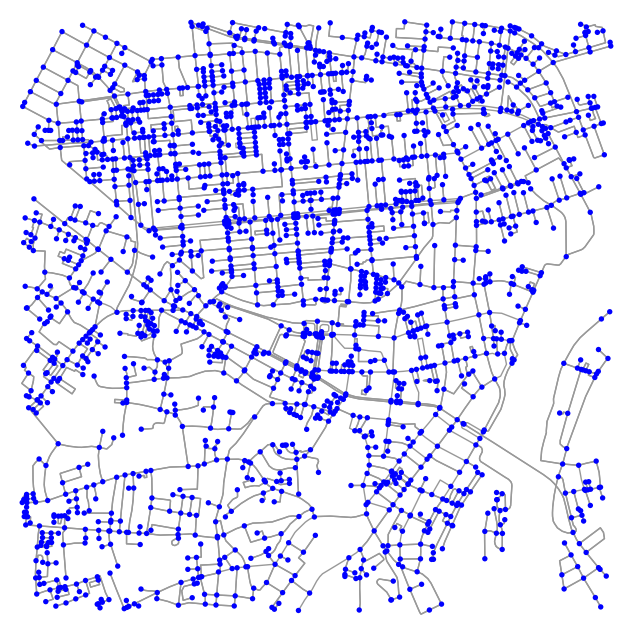

In [4]:
#prepare folders
check_folders()
#download network
G = download_nwk(areas['ishinomkai'][0],areas['ishinomkai'][1],1000,show=False, save=True)
#set seed for replication
np.random.seed(10)
#choose randomnly 4 nodes for evacuation
evacnodes = np.random.choice(G.nodes, size=4)
#prepare databases
Gdfn = get_nodedb(G, evacnodes=evacnodes)
Gdfe = get_edgedb(G)
get_fake_population(times=1)
get_actionsdb_transitionsdb()
#run evacuation model (RL)
main.main()